## Workshop 2

Programación SIG  2025-1S    
Universidad Nacional de Colombia    
Alicia Arévalo Robinson

1. Import modules

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path
from shapely.geometry import Point

2. Read files path

In [2]:
# Main folder
root_folder = "notebooks/GIS_Programming_Data"

# Path to municipios_colombia.shp
shp_path = root_folder + "/municipios_colombia.shp"
# Read the shapefile using geopandas
muni = gpd.read_file(shp_path)

# Path to Evaluaciones_Agropecuarias_Municipales_EVA.csv
eva_path = root_folder + "/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

# Path to Catalogo_Estaciones_IDEAM.csv"
stations_path = root_folder + "/Catalogo_Estaciones_IDEAM.csv"

# Path to precipitacion.csv"
precip_path = root_folder + "/precipitacion.csv"

3. Read CSV files

In [3]:
eva = pd.read_csv(eva_path, encoding='utf-8')
ideam = pd.read_csv(stations_path,encoding='utf-8')  
precip= pd.read_csv(precip_path, encoding='utf-8')

4. Read `ideam` as a `GeoDataGrame`

In [4]:
# Convert string coordinates to Points using string manipulation
ideam['geometry'] = ideam['Ubicación'].apply(
    lambda x: Point(
        float(x.strip('()').split(',')[1]),  # longitude
        float(x.strip('()').split(',')[0])   # latitude
    )
)

# Create GeoDataFrame
ideam_gdf = gpd.GeoDataFrame(
    ideam,
    geometry='geometry',
    crs="EPSG:4326"  # Standard lat/lon coordinates
)

# Reproject to match other layers
ideam_gdf = ideam_gdf.to_crs(3116)
ideam_gdf

,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,POINT (600756.451 581928.953)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,POINT (619813.515 594819.542)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,POINT (603583.628 610380.015)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,POINT (711679.061 611630.534)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,POINT (1412932.386 72873.368)
...,...,...,...,...,...,...,...,...,...,...,...,...
8968,4401700167,NIVEL SANGOYACO GARGANTA,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15872222, -76.67080556)",761,2020-02-25,NaN,Mocoa,POINT (711274.883 620024.782)
8969,4401700168,NIVEL MULATO PALMERAS,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15638889, -76.69027778)",966,2020-02-25,NaN,Mocoa,POINT (709105.196 619768.499)
8970,4401700172,NIVEL MOCOA PISCIKART,Limnimétrica,Activa,Putumayo,Villagarzón,"(1.03964167, -76.61091944)",408,2020-02-25,NaN,Mocoa,POINT (717935.55 606838.488)
8971,4401700173,NIVEL RUMIYACO LAGARTO,Limnimétrica,Activa,Putumayo,Mocoa,"(1.119225, -76.67045)",647,2020-02-25,NaN,Mocoa,POINT (711310.561 615652.849)


5. Plot

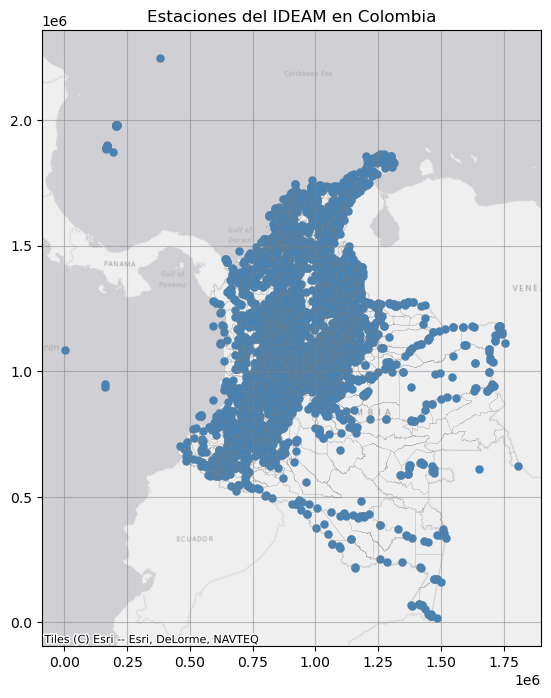

In [31]:
ax = ideam_gdf.plot(
    color='steelblue',
    legend=True,
    figsize=(8, 8),
    edgecolor='grey', linewidth=0.1
)

# Add all municipalities as a background
muni.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.1, zorder=1)

# Add a basemap 
cx.add_basemap(ax, crs=muni.crs,source=cx.providers.Esri.WorldGrayCanvas)

ax.set_title(f'Estaciones del IDEAM en Colombia')
#ax.set_axis_off() 
ax.grid(True,color='gray', alpha=0.5) 
plt.show()